# IronKaggle

## You have a dataset containing information on shops’ sales per day (and several characteristics of them) - your goal is to predict the sales!

### Training data (640841 entries): we will share with you a training set of store sales per day, with bits of information of what happened in that day in that store.

### Real-Life Data (+70k entries): we will also share with you entries without the sales. This will be used (on the teachers side) to verify how good your model really is!

### Expected Deliver:
- “Real-life data set” with an extra column called “sales”, with your predictions (in .csv)
- An expected value of R2 of performance of your model
- A 5’ presentation on the choices you did and the road you took

In [83]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns

# Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Model Training 
from sklearn.model_selection import train_test_split, cross_val_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Early stop to save time
from tensorflow.keras.callbacks import EarlyStopping

# Evaluate models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# Data Exploration

For this project I'll be using the sales.csv data set and so I'll begin by exploring the data and checking for any missing vaules.

In [54]:
data = pd.read_csv('sales.csv')

In [55]:
# Visualize first rows of the data
data.head()

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
0,425390,366,4,2013-04-18,517,1,0,0,0,4422
1,291687,394,6,2015-04-11,694,1,0,0,0,8297
2,411278,807,4,2013-08-29,970,1,1,0,0,9729
3,664714,802,2,2013-05-28,473,1,1,0,0,6513
4,540835,726,4,2013-10-10,1068,1,1,0,0,10882


In [58]:
# Information about the data |set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           640840 non-null  int64 
 1   store_ID             640840 non-null  int64 
 2   day_of_week          640840 non-null  int64 
 3   date                 640840 non-null  object
 4   nb_customers_on_day  640840 non-null  int64 
 5   open                 640840 non-null  int64 
 6   promotion            640840 non-null  int64 
 7   state_holiday        640840 non-null  object
 8   school_holiday       640840 non-null  int64 
 9   sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB


In [60]:
data['state_holiday'].unique()

array(['0', 'a', 'c', 'b'], dtype=object)

## Processing data into numerical values

In [63]:
from sklearn.preprocessing import OneHotEncoder
# Process the 'date' column
# Convert 'date' to datetime format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Extract relevant features from the date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek                    # 0 = Monday, 6 = Sunday
data['is_weekend'] = (data['date'].dt.dayofweek >= 5).astype(int)  # 1 if weekend, 0 otherwise

# Drop the original 'date' column if no longer needed
data.drop(columns=['date'], inplace=True)

# Process the 'state_holiday' column
# Initialize one-hot encoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Dropping first category to avoid multicollinearity

# Fit-transform 'state_holiday'
state_holiday_encoded = encoder.fit_transform(data[['state_holiday']])

# Convert the encoded result into a DataFrame
state_holiday_df = pd.DataFrame(
    state_holiday_encoded, 
    columns=encoder.get_feature_names_out(['state_holiday'])
)

# Add the new one-hot encoded columns to the main DataFrame
data = pd.concat([data, state_holiday_df], axis=1)

# Drop the original 'state_holiday' column
data.drop(columns=['state_holiday'], inplace=True)

In [65]:
# Check
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           640840 non-null  int64  
 1   store_ID             640840 non-null  int64  
 2   day_of_week          640840 non-null  int32  
 3   nb_customers_on_day  640840 non-null  int64  
 4   open                 640840 non-null  int64  
 5   promotion            640840 non-null  int64  
 6   school_holiday       640840 non-null  int64  
 7   sales                640840 non-null  int64  
 8   year                 640840 non-null  int32  
 9   month                640840 non-null  int32  
 10  day                  640840 non-null  int32  
 11  is_weekend           640840 non-null  int32  
 12  state_holiday_a      640840 non-null  float64
 13  state_holiday_b      640840 non-null  float64
 14  state_holiday_c      640840 non-null  float64
dtypes: float64(3), in

# Training the Model

- Separate Features and target variable
- Split data into test and training
- Scale the data

In [28]:
# Separate Features and Target Variable
X = data.drop(columns=['sales'])  # Replace 'sales' with the name of your target column
y = data['sales']

# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose and Apply a Scaler
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check Scaled Data
print("Before scaling:", X_train.iloc[0])
print("After scaling:", X_train_scaled[0])

Before scaling: Unnamed: 0             346971.0
store_ID                  275.0
day_of_week                 2.0
nb_customers_on_day       680.0
open                        1.0
promotion                   1.0
school_holiday              0.0
year                     2015.0
month                       7.0
day                        29.0
is_weekend                  0.0
state_holiday_a             0.0
state_holiday_b             0.0
state_holiday_c             0.0
Name: 360184, dtype: float64
After scaling: [-0.04313508 -0.87880299 -0.50115648  0.10017559  0.45221223  1.2725205
 -0.46547853  1.50338982  0.34711046  1.51226025 -0.63108744 -0.14262637
 -0.08094245 -0.06445413]


In [30]:
# Check the shape of training and test data
print("Training Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Test Labels Shape:", y_test.shape)

Training Features Shape: (512672, 14)
Test Features Shape: (128168, 14)
Training Labels Shape: (512672,)
Test Labels Shape: (128168,)


# Correlation Matix

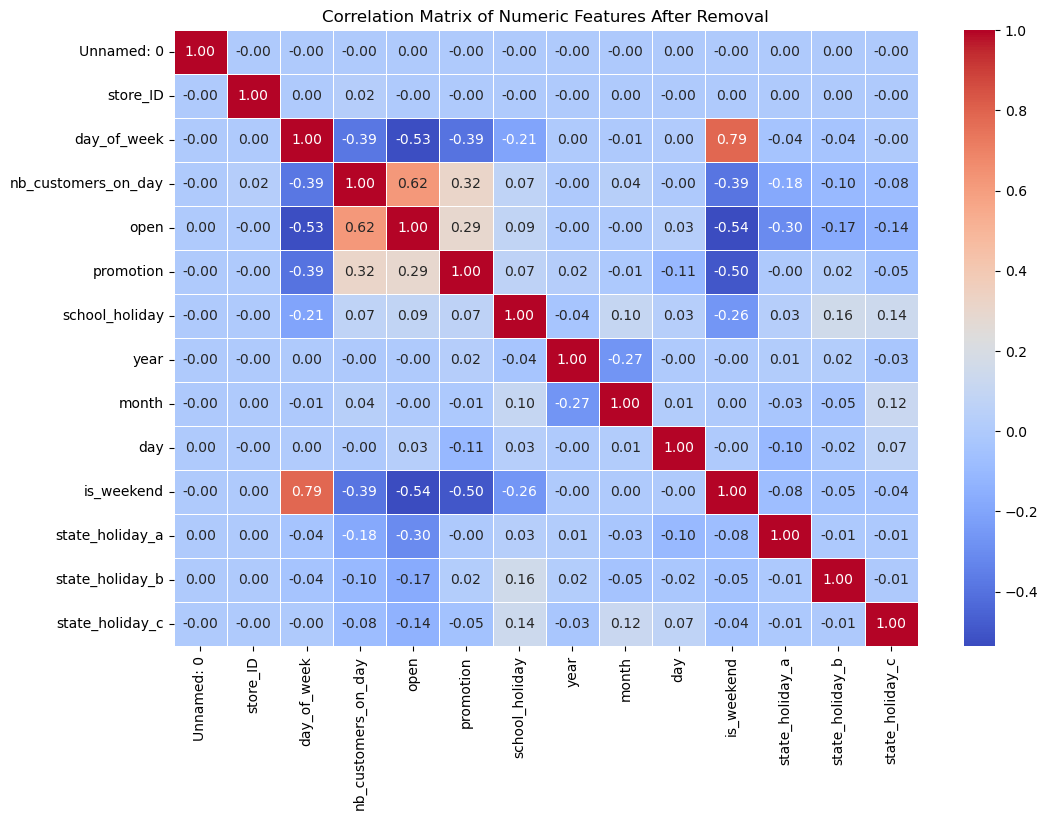

In [95]:
# Your code here
# Print the new correlation matrix after removal
corr_matrix = X.corr()

# Plot the heatmap again to visualize the correlation after removal
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features After Removal')
plt.show()

# Model Evaluation

In [69]:
# Assuming `X` are features and `y` is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    #"LightGBM": LGBMRegressor(n_estimators=100, random_state=42)
}

# Evaluate each model
results = []
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store results
    results.append({"Model": name, "R²": r2, "MAE": mae, "RMSE": rmse})

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print(results_df)

               Model        R²         MAE         RMSE
3      Random Forest  0.944977  564.307976   901.847251
4            XGBoost  0.932405  679.570707   999.585373
0  Linear Regression  0.853925  983.024238  1469.431256
1   Ridge Regression  0.853925  983.022791  1469.431300
2   Lasso Regression  0.853925  982.911047  1469.433536


## Model

In [87]:
# Initialize the model
xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.5, max_depth=6)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.9370
MAE: 653.6943
RMSE: 964.6445


### Graph to visualize how the training and test data are performing

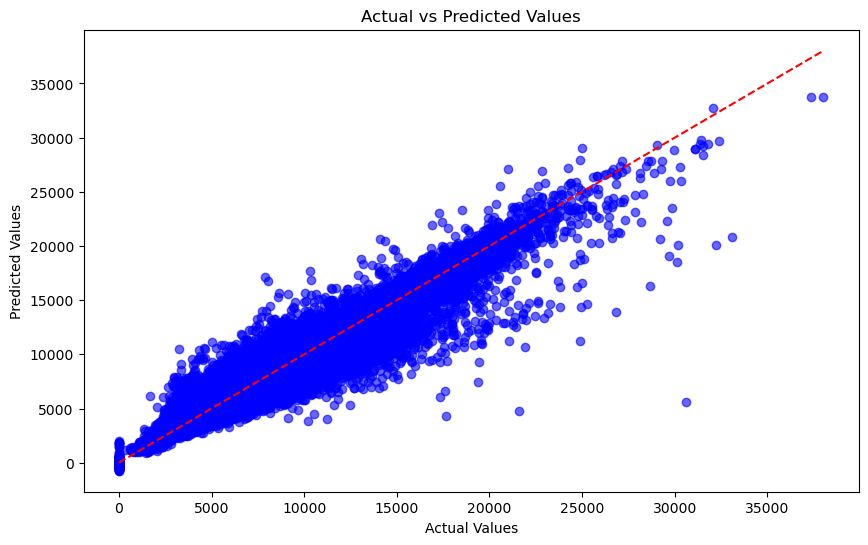

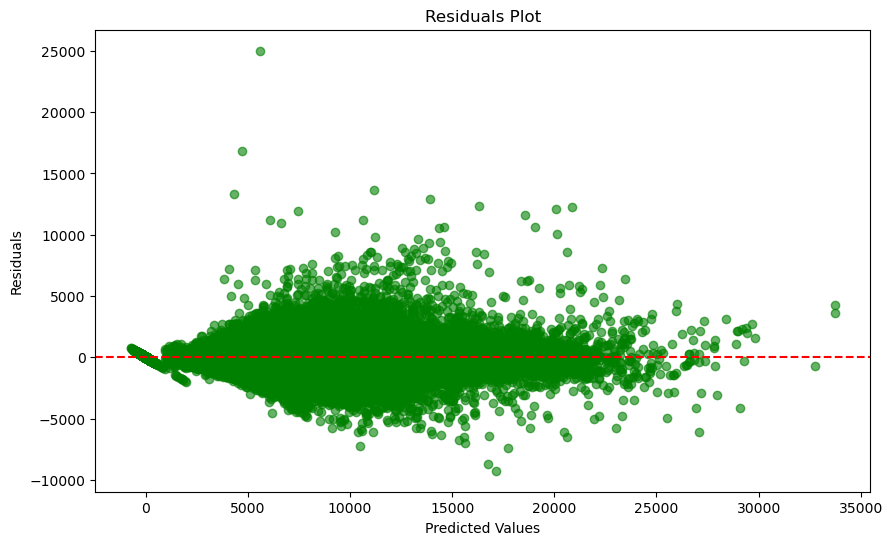

In [89]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

# Residuals Plot
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

# Save the model

In [91]:
# Save the model
xgb_model.save_model('xgboost_model_ironkaggle.json')

# Load the Model
Important Notes:
- Preprocessing: Ensure that the same transformations (e.g., scaling, encoding) applied during training are also applied to the new dataset.
- Feature Alignment: Ensure that the feature columns in the new dataset match the ones used during training in both order and type.
- Handling Missing Values: If you had to handle missing values during training, make sure to apply the same strategy (e.g., imputation) to the new dataset.

In [ ]:
# Load the model from the file
loaded_model = XGBRegressor()
loaded_model.load_model('xgboost_model_ironkaggle.json')